## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

## My functions

In [136]:
def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

def draw_Qtable(Q_table,table_size):
    # Create a directed graph
    G = nx.MultiDiGraph()
    # Add nodes to the graph
    states = set()
    for state in Q_table.keys():
        states.add(state[0])
    max_x = max(states,key=lambda x: x[0])[0]
    max_y = max(states,key=lambda x: x[1])[1]
    # Add edges to the graph with rewards as weights
    for (state, action), reward in Q_table.items():
        next_state = None
        if action == 'L':
            next_state = (state[0], state[1] - 1)
        elif action == 'R':
            next_state = (state[0], state[1] + 1)
        elif action == 'U':
            next_state = (state[0] - 1, state[1])
        elif action == 'D':
            next_state = (state[0] + 1, state[1])
        
        if 0<=next_state[0]<=max_x and 0<=next_state[1]<=max_y:
            G.add_edge(state, next_state, weight=round(reward,1))
    
    # Draw the graph
    pos=nx.spring_layout(G,seed=5)
    def matrix_to_cartesian(matrix_coord, matrix_width, matrix_height):
        x = matrix_coord[1]
        y = matrix_height - matrix_coord[0] - 1
        return (x, y)

    colors = []
    c_map = {'W':'white','B':'red','F':'green','T':'yellow','A':'blue'}
    for k,v in pos.items():
        pos[k]=matrix_to_cartesian((k[0],k[1]),*table_size)
        colors.append(c_map[environment[k[0]][k[1]]])
    plt_size = 20 if table_size[0]<6 else 30
    fig, ax = plt.subplots(figsize=(plt_size, plt_size))
    nx.draw_networkx_nodes(G, pos, ax=ax,node_shape = 's',node_size = 4000,
                          node_color = colors, edgecolors='k')
    nx.draw_networkx_labels(G, pos, ax=ax,font_size = 20)
    curved_edges = [edge for edge in G.edges() if (edge[1],edge[0]) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges,node_shape = 's',node_size = 4000)
    arc_rad = 0.25
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges,node_shape = 's',node_size = 4000,
                           connectionstyle=f'arc3, rad = {arc_rad}',width = 4)

    edge_weights = nx.get_edge_attributes(G,'weight')
    curved_edge_labels = {edge: edge_weights[(edge[0],edge[1],0)] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[(edge[0],edge[1],0)] for edge in straight_edges}
    my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,
                                 rotate=False,rad = arc_rad,font_size=10)

In [105]:
def get_valid_actions(environment,state):
    valid_actions = []
    if state[1] > 0 and environment[state[0]][state[1]-1] != 'B':
        valid_actions.append('L')
    if state[1] < len(environment[0])-1 and environment[state[0]][state[1]+1] != 'B':
        valid_actions.append('R')
    if state[0] > 0 and environment[state[0]-1][state[1]] != 'B':
        valid_actions.append('U')
    if state[0] < len(environment)-1 and environment[state[0]+1][state[1]] != 'B':
        valid_actions.append('D')
    return valid_actions
def any_flag_target(environment):
    a = np.array(environment).flatten()
    return ('T' in a) or ('F' in a)
def any_flag(environment):
    a = np.array(environment).flatten()
    return ('F' in a)
    
# Define the reward table
def get_reward(state,environment):
    return reward_map[environment[state[0]][state[1]]]

def Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count,prnt=False):
    # Define the actions (left, right, up, down)
    actions = ['L', 'R', 'U', 'D']

    # Define the state space
    states = []
    for i in range(len(environment)):
        for j in range(len(environment[0])):
            states.append((i, j))

    # Define the Q-table
    Q = {}
    for state in states:
        for action in actions:
            Q[(state, action)] = 0

    # Define the agent's starting position
    start_state = None
    for state in states:
        if environment[state[0]][state[1]] == 'A':
            start_state = state
            break

    # Start the Q-Learning algorithm
    epsilon_decrease = epsilon/episode_count
    for episode in range(episode_count):
        if episode%1000==0:
            print(f'epoch: {episode}/{episode_count}')
        state = start_state
        cur_env = [list(e) for e in np.array(environment)]
        target_seen = False
        episode_len = 0
        env_size = len(cur_env)*len(cur_env[0])
        epsilon = epsilon - epsilon_decrease
        while (episode_len<env_size or not target_seen) and episode_len<1.5*env_size:
            episode_len+=1
            # Choose an action
            valid_actions = get_valid_actions(cur_env,state)
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(valid_actions)
            else:
                max_q = -1000000
                action_q = None
                for a in valid_actions:
                    q = Q[(state, a)]
                    if q > max_q:
                        max_q = q
                        action_q = a
                action = action_q

            # Take the action and get the new state and reward
            if action == 'L':
                new_state = (state[0], state[1]-1)
            elif action == 'R':
                new_state = (state[0], state[1]+1)
            elif action == 'U':
                new_state = (state[0]-1, state[1])
            elif action == 'D':
                new_state = (state[0]+1, state[1])
                
            reward = get_reward(new_state,cur_env)

            # Update the Q-table
            max_q = -1000000
            for a in actions:
                q = Q[(new_state, a)]
                if q > max_q:
                    max_q = q
            Q[(state, action)] = (1-alpha) * Q[(state, action)] + alpha * (reward + gamma * max_q)

            # Update the state & environment(Delete flag)
            state = new_state
            if cur_env[state[0]][state[1]]=='F':
                cur_env[state[0]][state[1]] = 'W' 
            if cur_env[state[0]][state[1]]=='T':
                cur_env[state[0]][state[1]] = 'W' 
                target_seen = True
            if not any_flag_target(cur_env):
                break

    # Print the final Q-table
    if prnt:
        print("Final Q-table:")
        for state in states:
            for action in actions:
                print("Q[{}, {}] = {}".format(state, action, Q[(state, action)]))
    return Q

In [86]:
def choose_next_state(environment,state,Q):
    valid_actions = get_valid_actions(environment,state)
    action_point = []
    for action_q in valid_actions:
        cur_point = Q[(state, action_q)]
        if action_q == 'L':
            new_state = (state[0], state[1]-1)
        elif action_q == 'R':
            new_state = (state[0], state[1]+1)
        elif action_q == 'U':
            new_state = (state[0]-1, state[1])
        elif action_q == 'D':
            new_state = (state[0]+1, state[1])
        
        valid_next_action = get_valid_actions(environment,new_state)
        future_point = max([Q[(new_state, second_action)] for second_action in valid_next_action])
        
        point = np.mean([cur_point,future_point])
        action_point.append(point)
    action_point = np.array(action_point)
    if min(action_point)<0:
        action_point = action_point+min(action_point)+10
    action_point = action_point/sum(action_point)
    return np.random.choice(valid_actions,p=action_point)
# Find the path from the Q-table
def get_path(environment_in,Q):
    environment = [list(e) for e in np.array(environment_in)]
    states = []
    for i in range(len(environment)):
        for j in range(len(environment[0])):
            states.append((i, j))
    for state in states:
        if environment[state[0]][state[1]] == 'A':
            start_state = state
            break
    state = start_state
    path = []
    reward = 0
    find_result = False
    while 1:
        action_q = choose_next_state(environment,state,Q)
        path.append((state, action_q))
        if action_q == 'L':
            state = (state[0], state[1]-1)
        elif action_q == 'R':
            state = (state[0], state[1]+1)
        elif action_q == 'U':
            state = (state[0]-1, state[1])
        elif action_q == 'D':
            state = (state[0]+1, state[1])
            
        if environment[state[0]][state[1]]=='T':
            if not any_flag(environment):
                find_result = True
                break
            else:
                pass
        else:
            reward+=get_reward(state,environment)
        
        if environment[state[0]][state[1]]=='F':
            environment[state[0]][state[1]] = 'W'
        if reward<reward_map['W']*len(environment)*len(environment[0]):
            break
        
    return find_result,reward,path

In [173]:
environment = [
    ['W', 'W', 'W', 'W', 'W'],
    ['W', 'B', 'W', 'B', 'W'],
    ['W', 'F', 'A', 'F', 'W'],
    ['W', 'B', 'W', 'B', 'W'],
    ['T', 'W', 'W', 'W', 'W']]

table_size = np.array(environment).shape
reward_map = {'B':-100,'F':30,'T':100,'W':-3,'A':-3}
# Define the learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.3
episode_count = 1000

In [174]:
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)

epoch: 0/1000


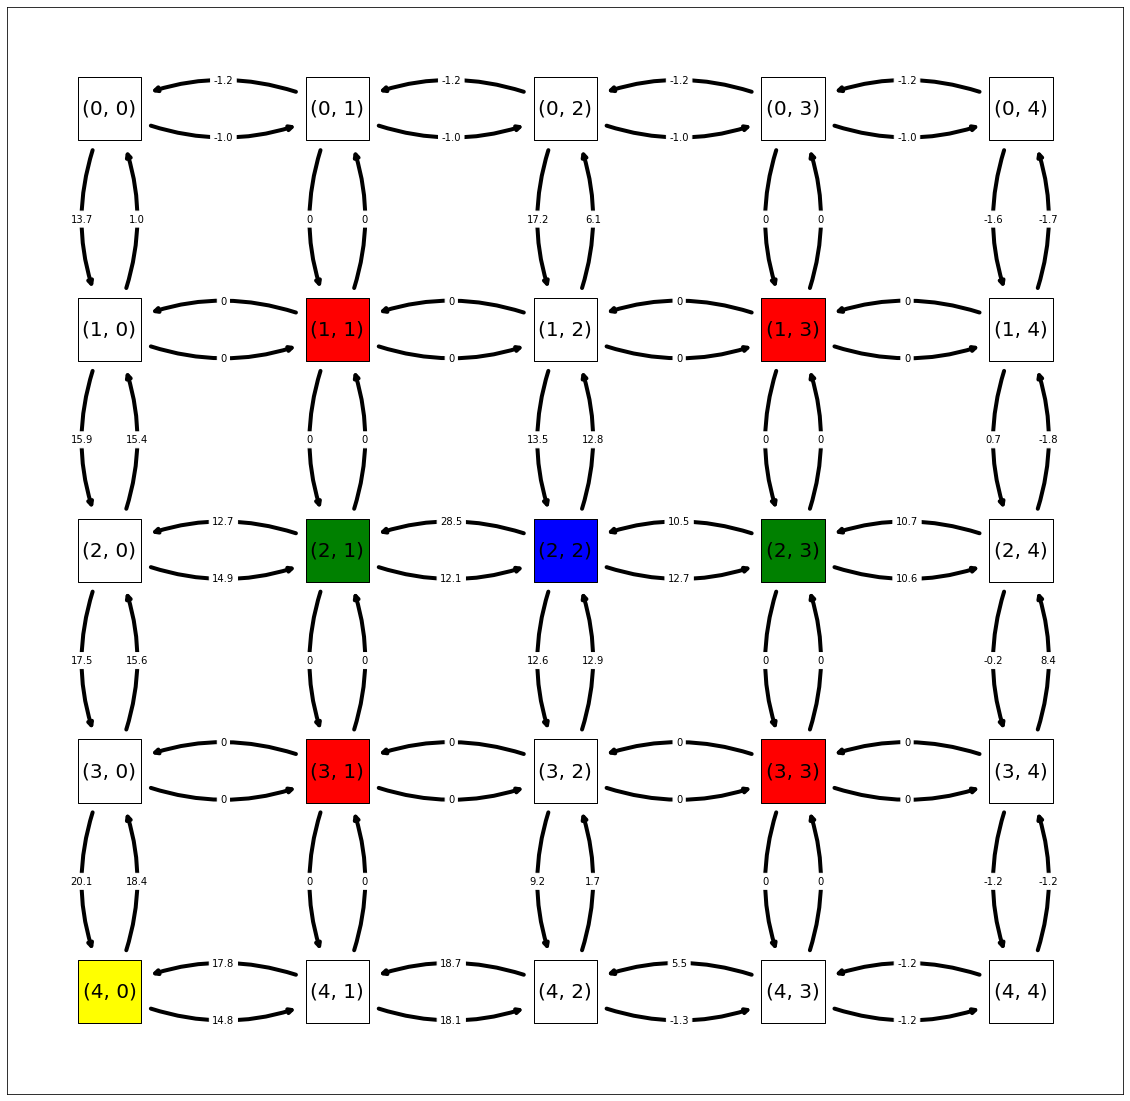

In [175]:
draw_Qtable(Q,table_size)

In [176]:
max_reward = -1000000
path_best = None
for i in range(1000):
    try:
        find_result,reward,path = get_path(environment,Q)
    except:
        continue
    if find_result and reward>max_reward:
        max_reward=reward
        path_best = path
path_best

[((2, 2), 'R'),
 ((2, 3), 'L'),
 ((2, 2), 'L'),
 ((2, 1), 'L'),
 ((2, 0), 'D'),
 ((3, 0), 'D')]

In [181]:
# Define the environment
environment = [
       ['A', 'B', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'F', 'W', 'B', 'W', 'W', 'W', 'W'],
       ['F', 'W', 'W', 'W', 'W', 'B', 'F', 'W', 'W', 'W'],
       ['B', 'B', 'W', 'B', 'B', 'W', 'B', 'W', 'W', 'W'],
       ['W', 'F', 'B', 'W', 'B', 'F', 'B', 'B', 'B', 'W'],
       ['W', 'W', 'B', 'W', 'B', 'W', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['W', 'F', 'W', 'W', 'W', 'W', 'B', 'B', 'B', 'B'],
       ['W', 'B', 'B', 'B', 'B', 'B', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'F', 'T']]
table_size = np.array(environment).shape
reward_map = {'B':-100,'F':300,'T':1000,'W':-3,'A':-3}
# Define the learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 1
episode_count = 2000
#Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)

epoch: 0/2000
epoch: 1000/2000


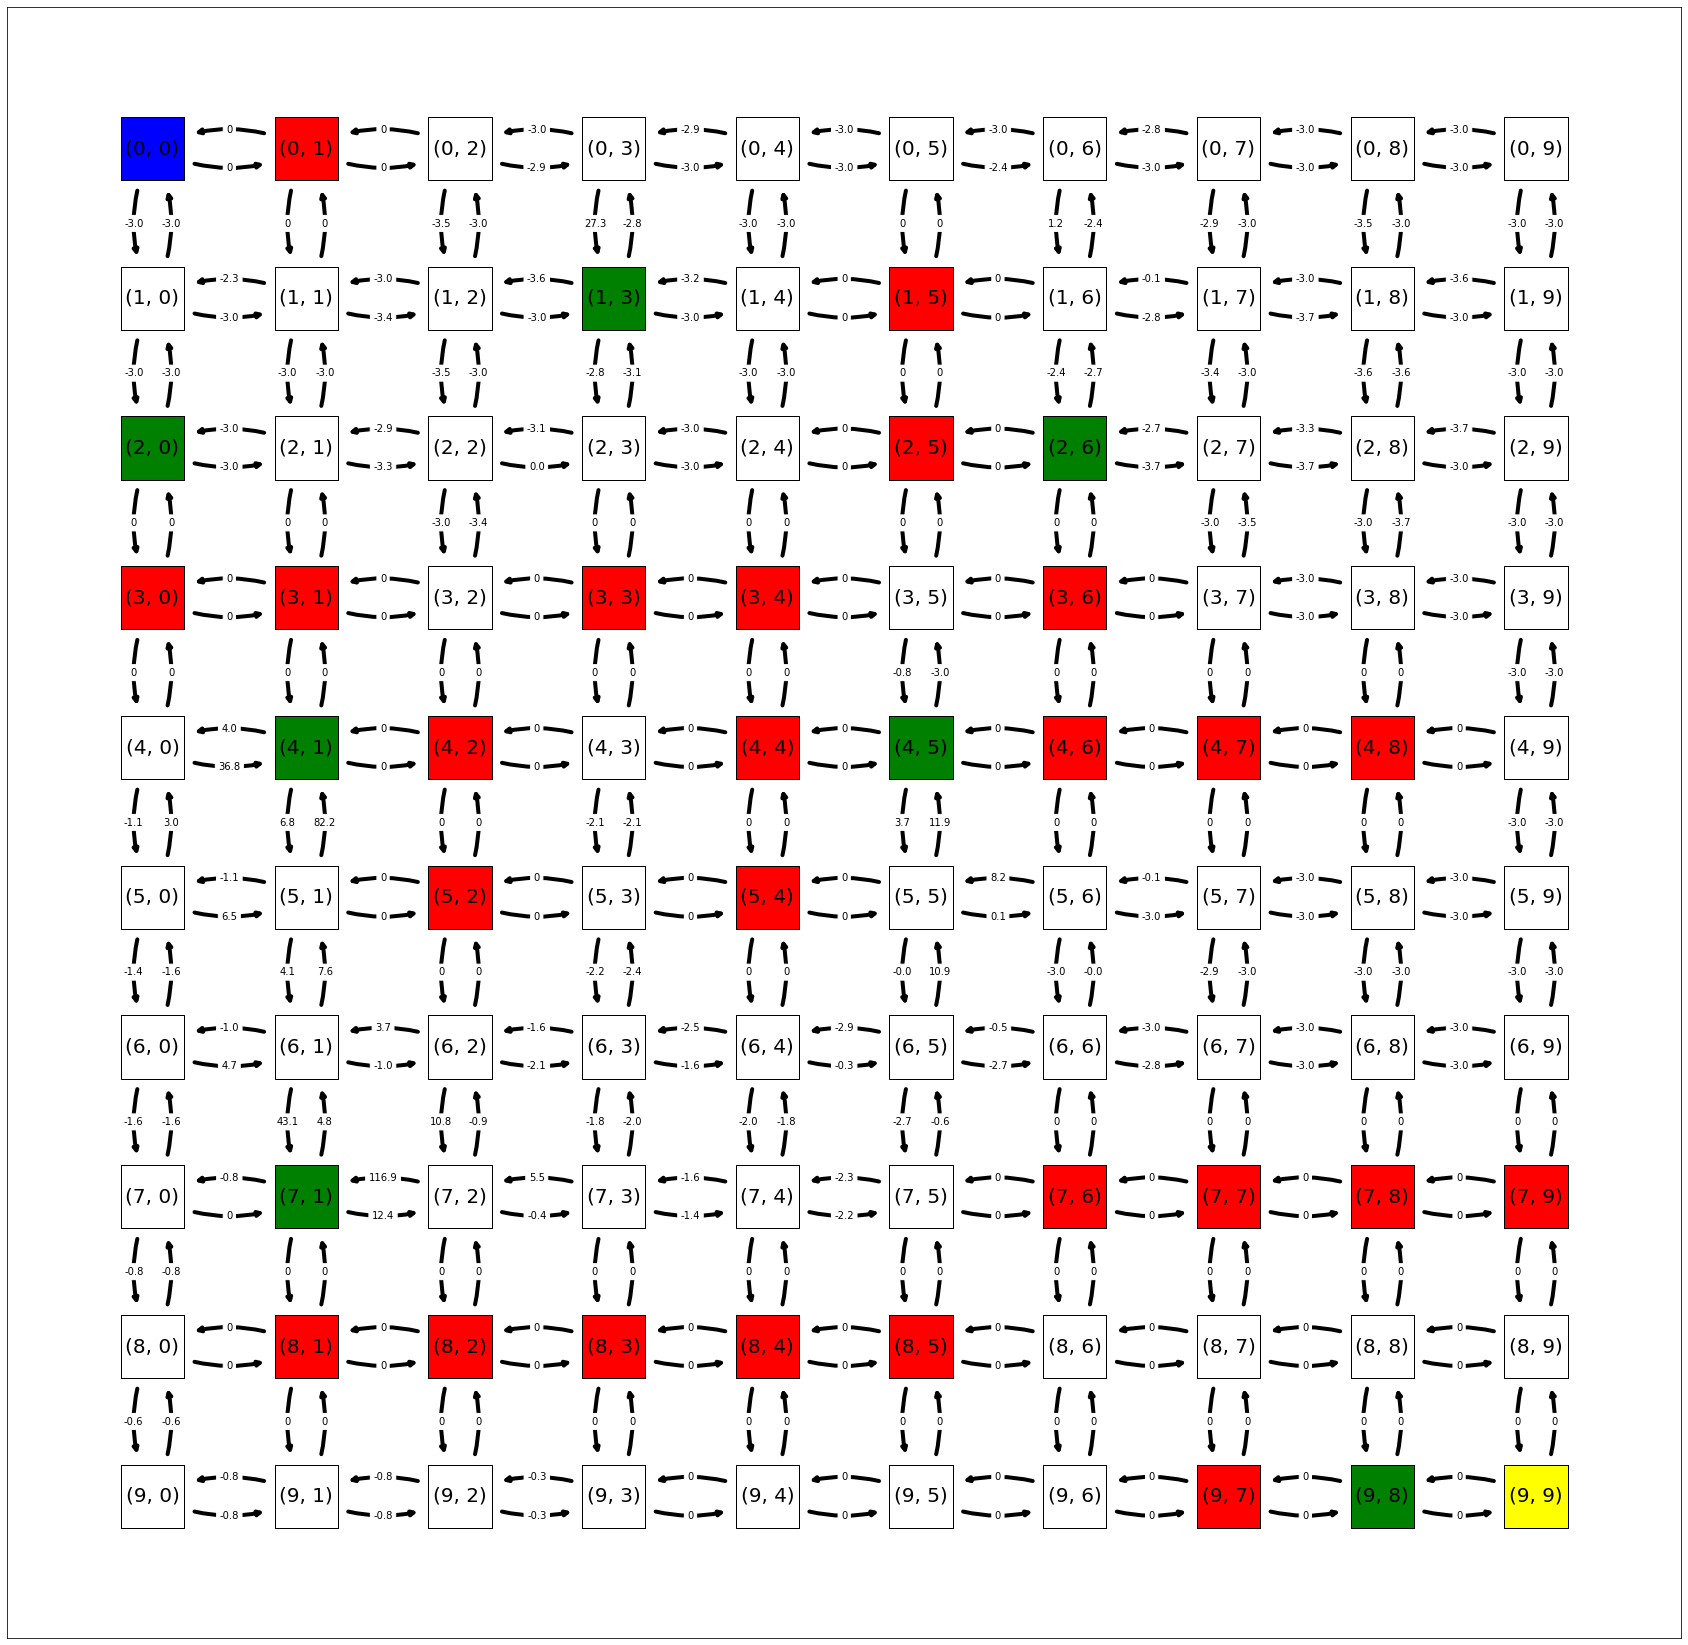

In [182]:
gamma = 0.25
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)
draw_Qtable(Q,table_size)

epoch: 0/2000
epoch: 1000/2000


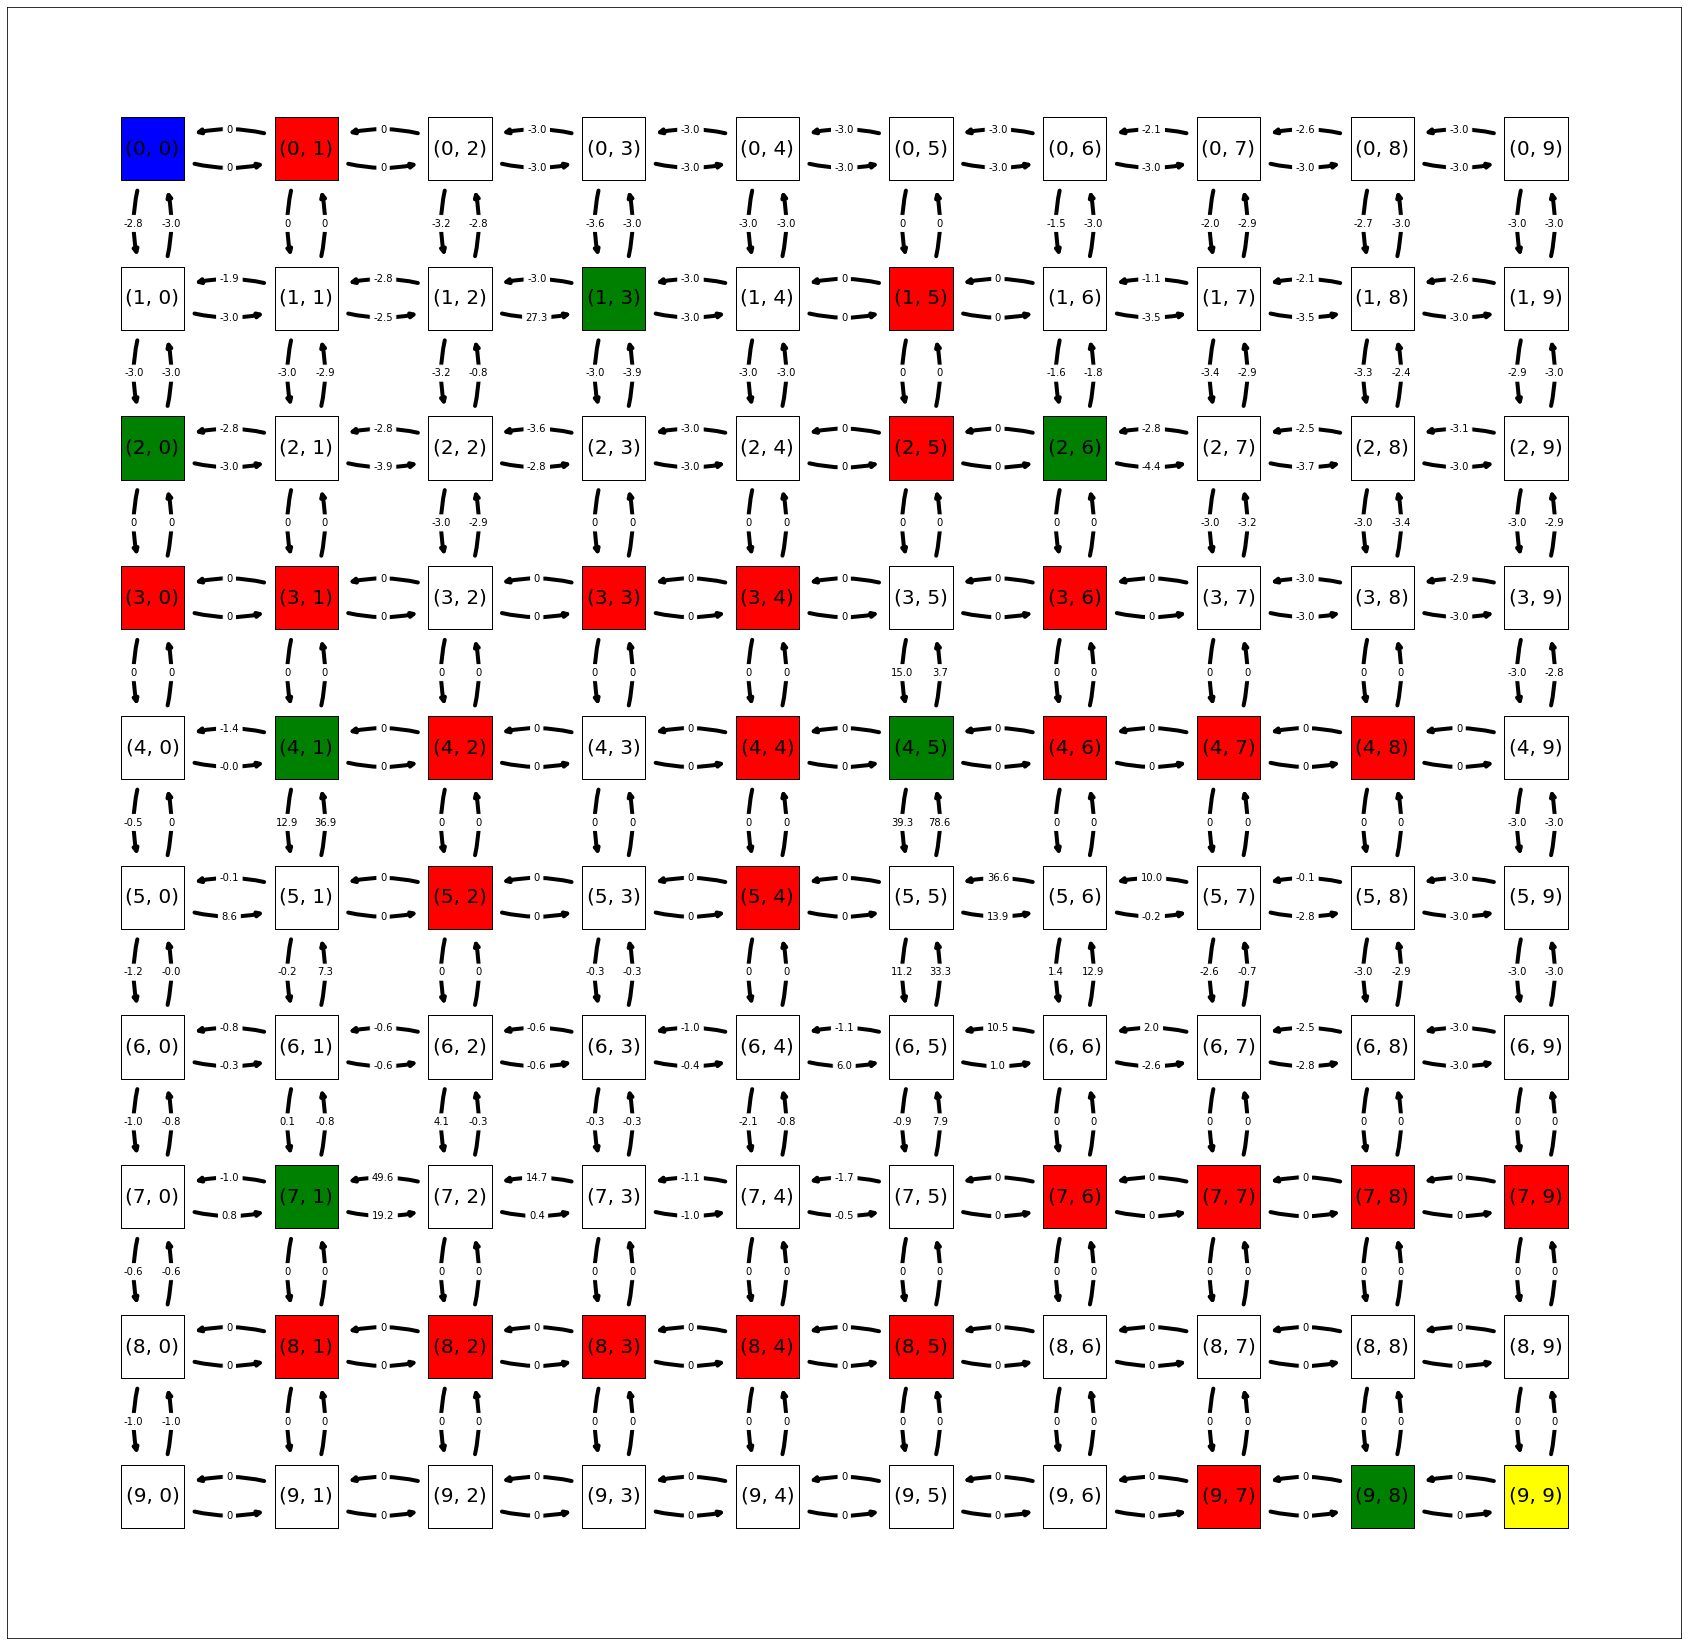

In [183]:
gamma = 0.5
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)
draw_Qtable(Q,table_size)

epoch: 0/2000
epoch: 1000/2000


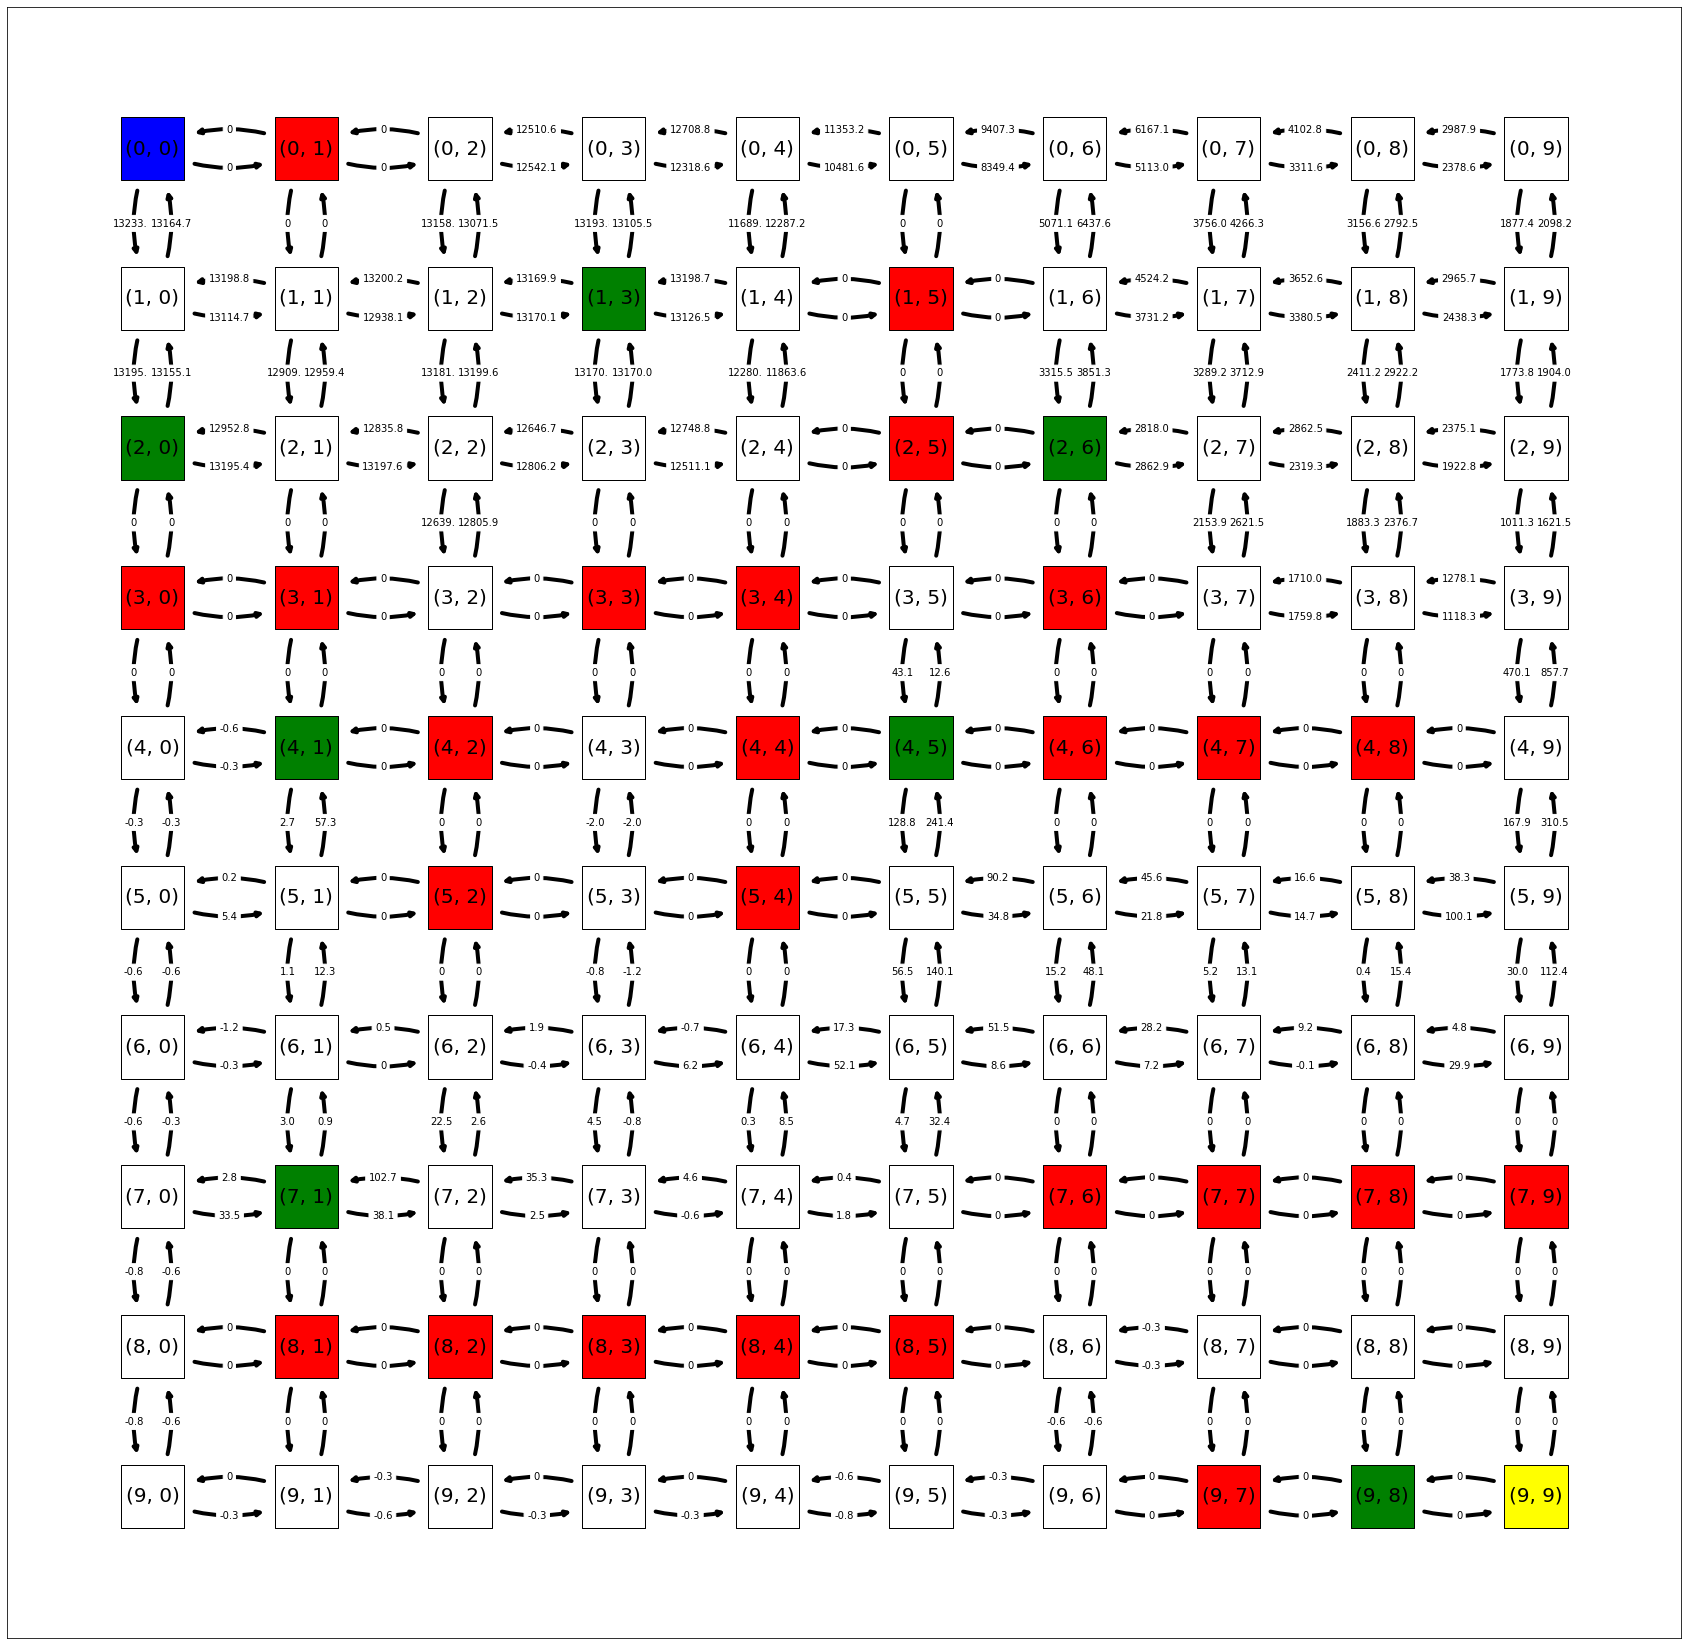

In [184]:
gamma = 1
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)
draw_Qtable(Q,table_size)

epoch: 0/2000
epoch: 1000/2000


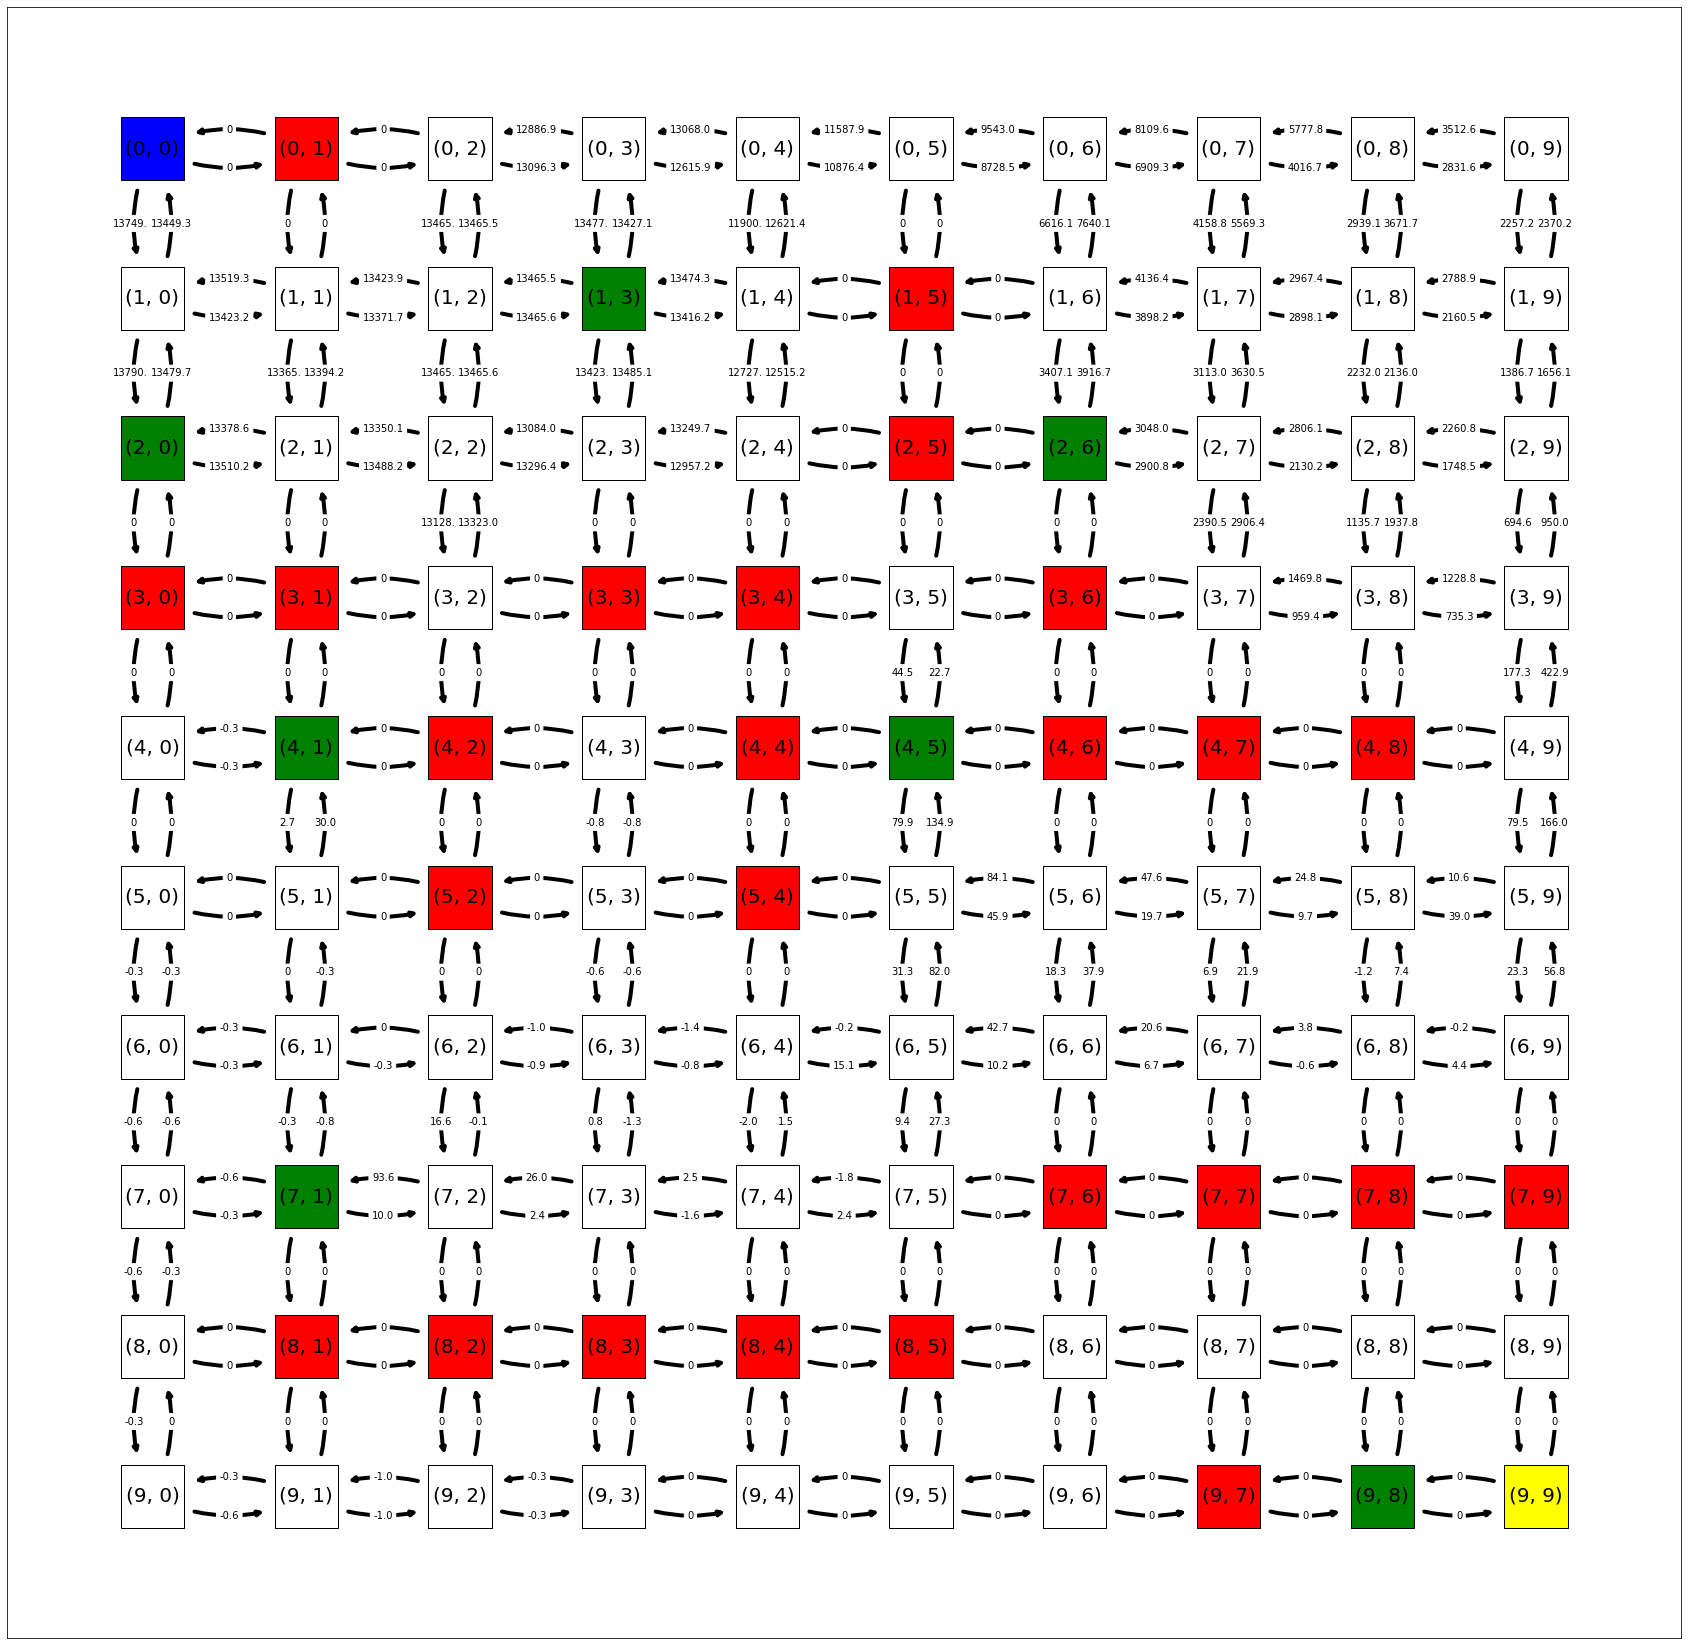

In [185]:
alpha = 0.1
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)
draw_Qtable(Q,table_size)

epoch: 0/2000
epoch: 1000/2000


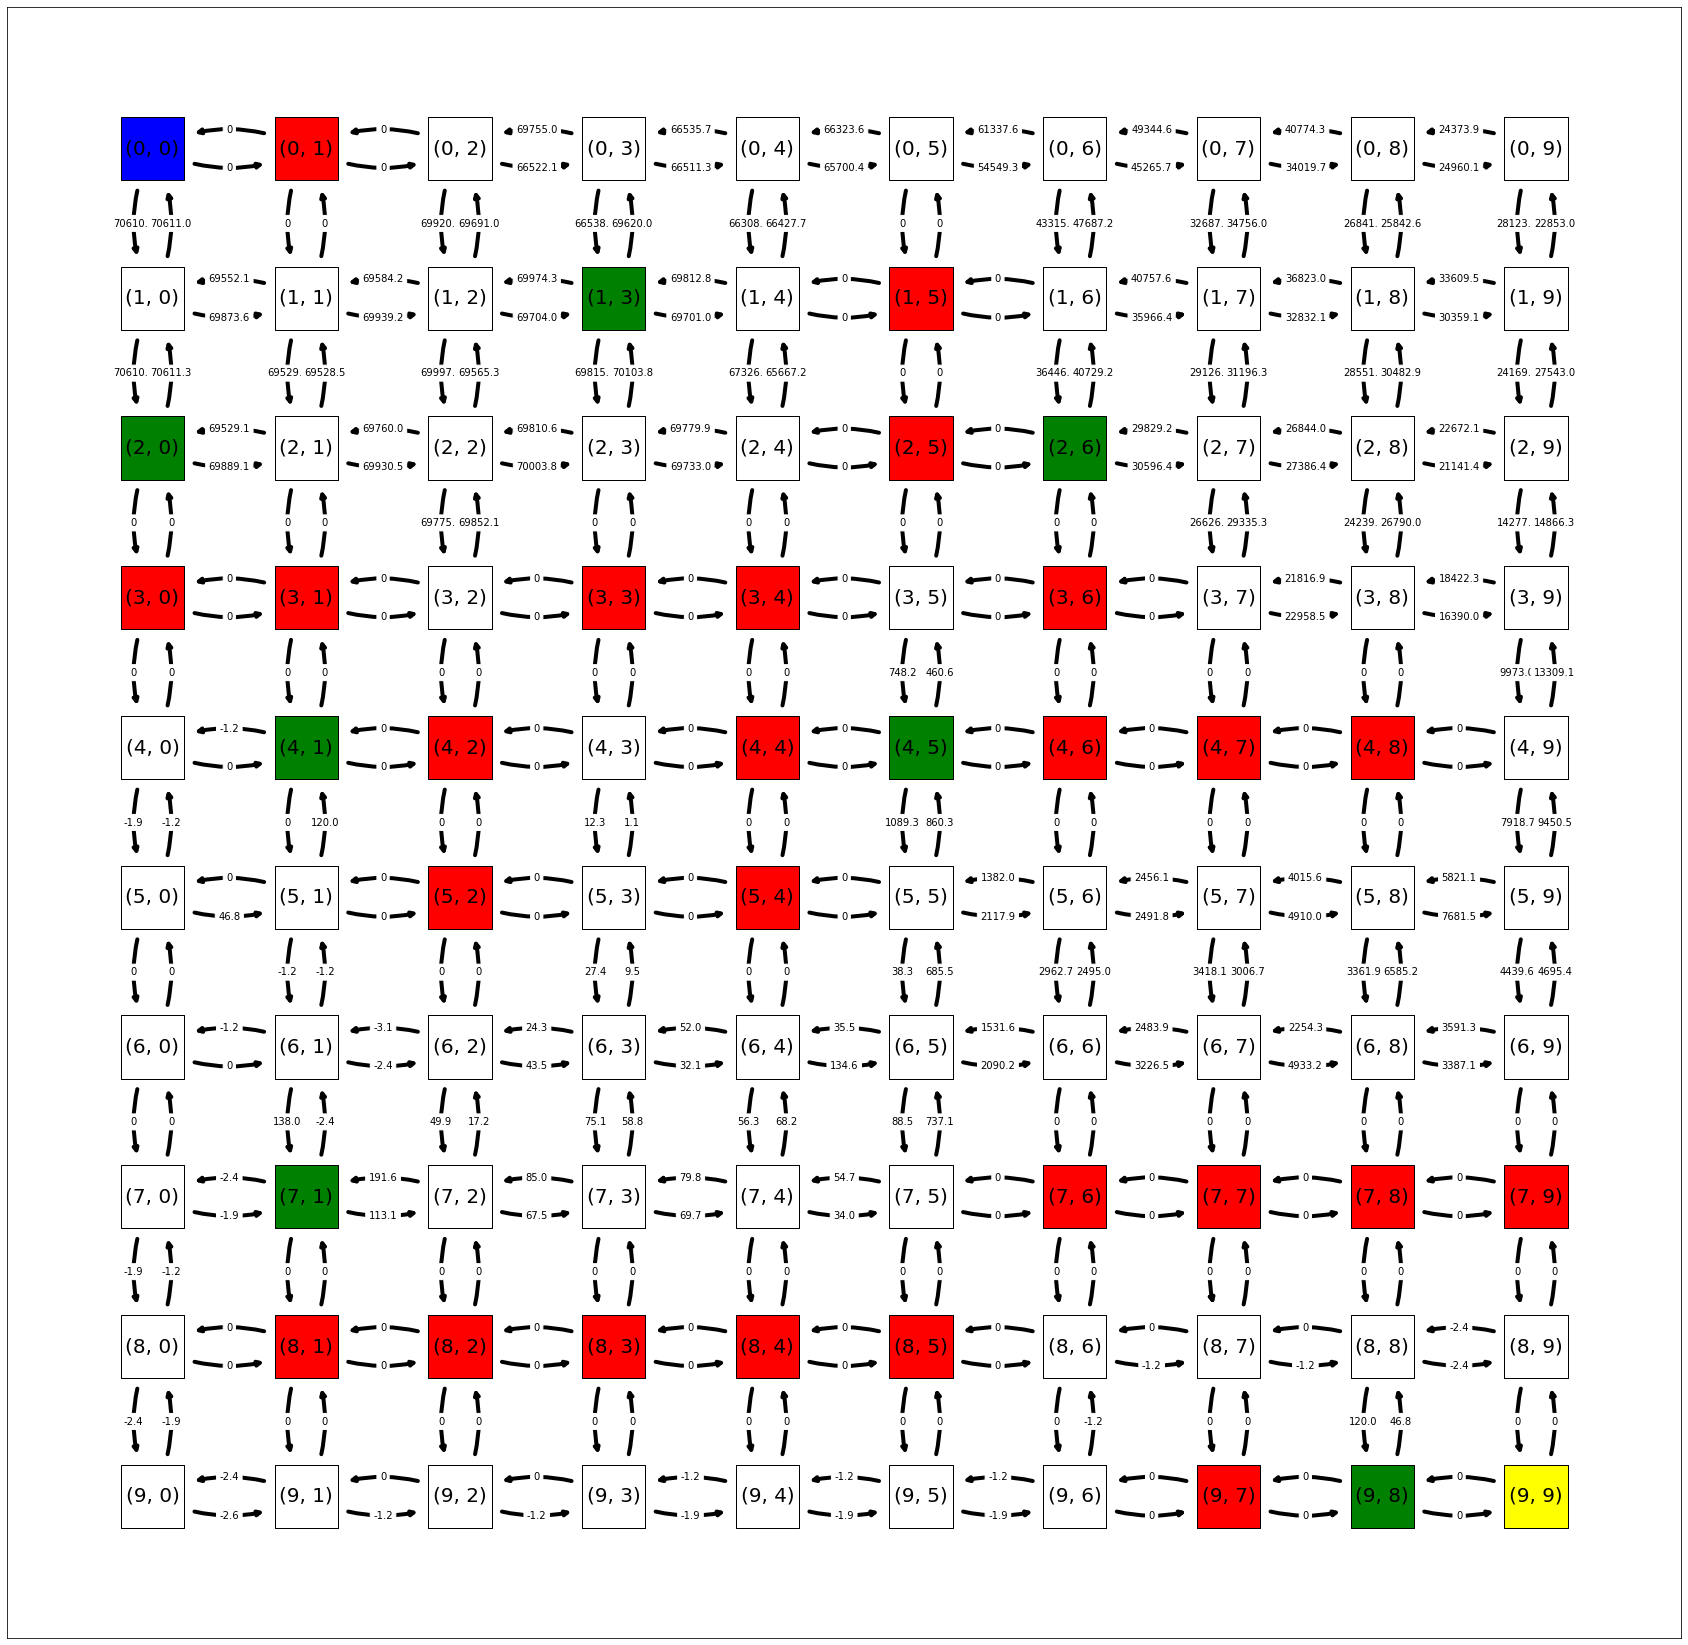

In [186]:
alpha = 0.4
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)
draw_Qtable(Q,table_size)

epoch: 0/2000
epoch: 1000/2000


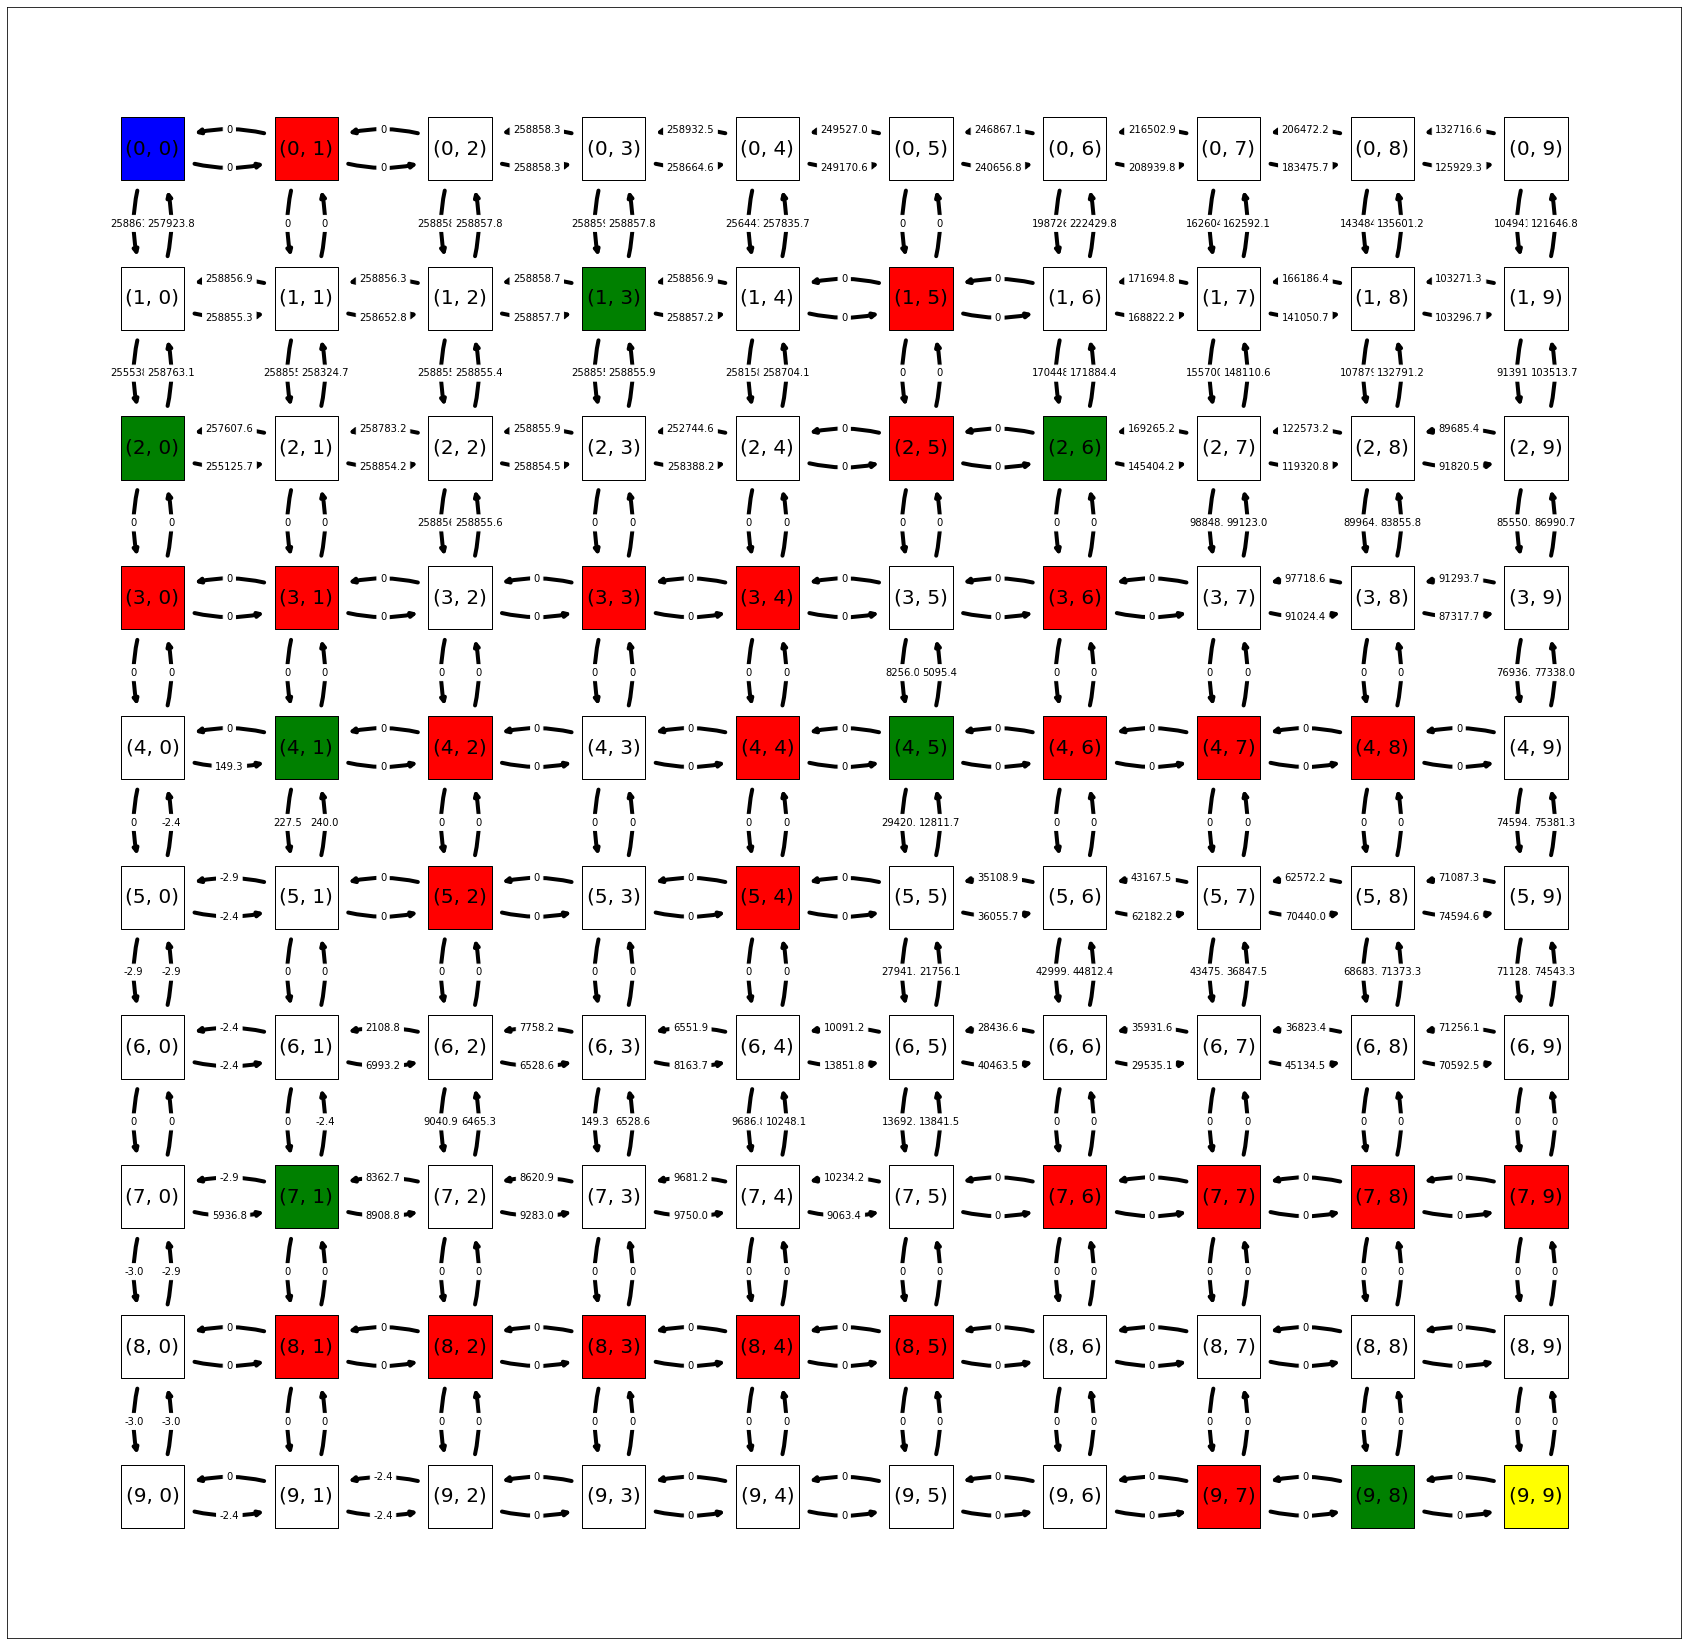

In [187]:
alpha = 0.8
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)
draw_Qtable(Q,table_size)

epoch: 0/10000
epoch: 1000/10000
epoch: 2000/10000
epoch: 3000/10000
epoch: 4000/10000
epoch: 5000/10000
epoch: 6000/10000
epoch: 7000/10000
epoch: 8000/10000
epoch: 9000/10000


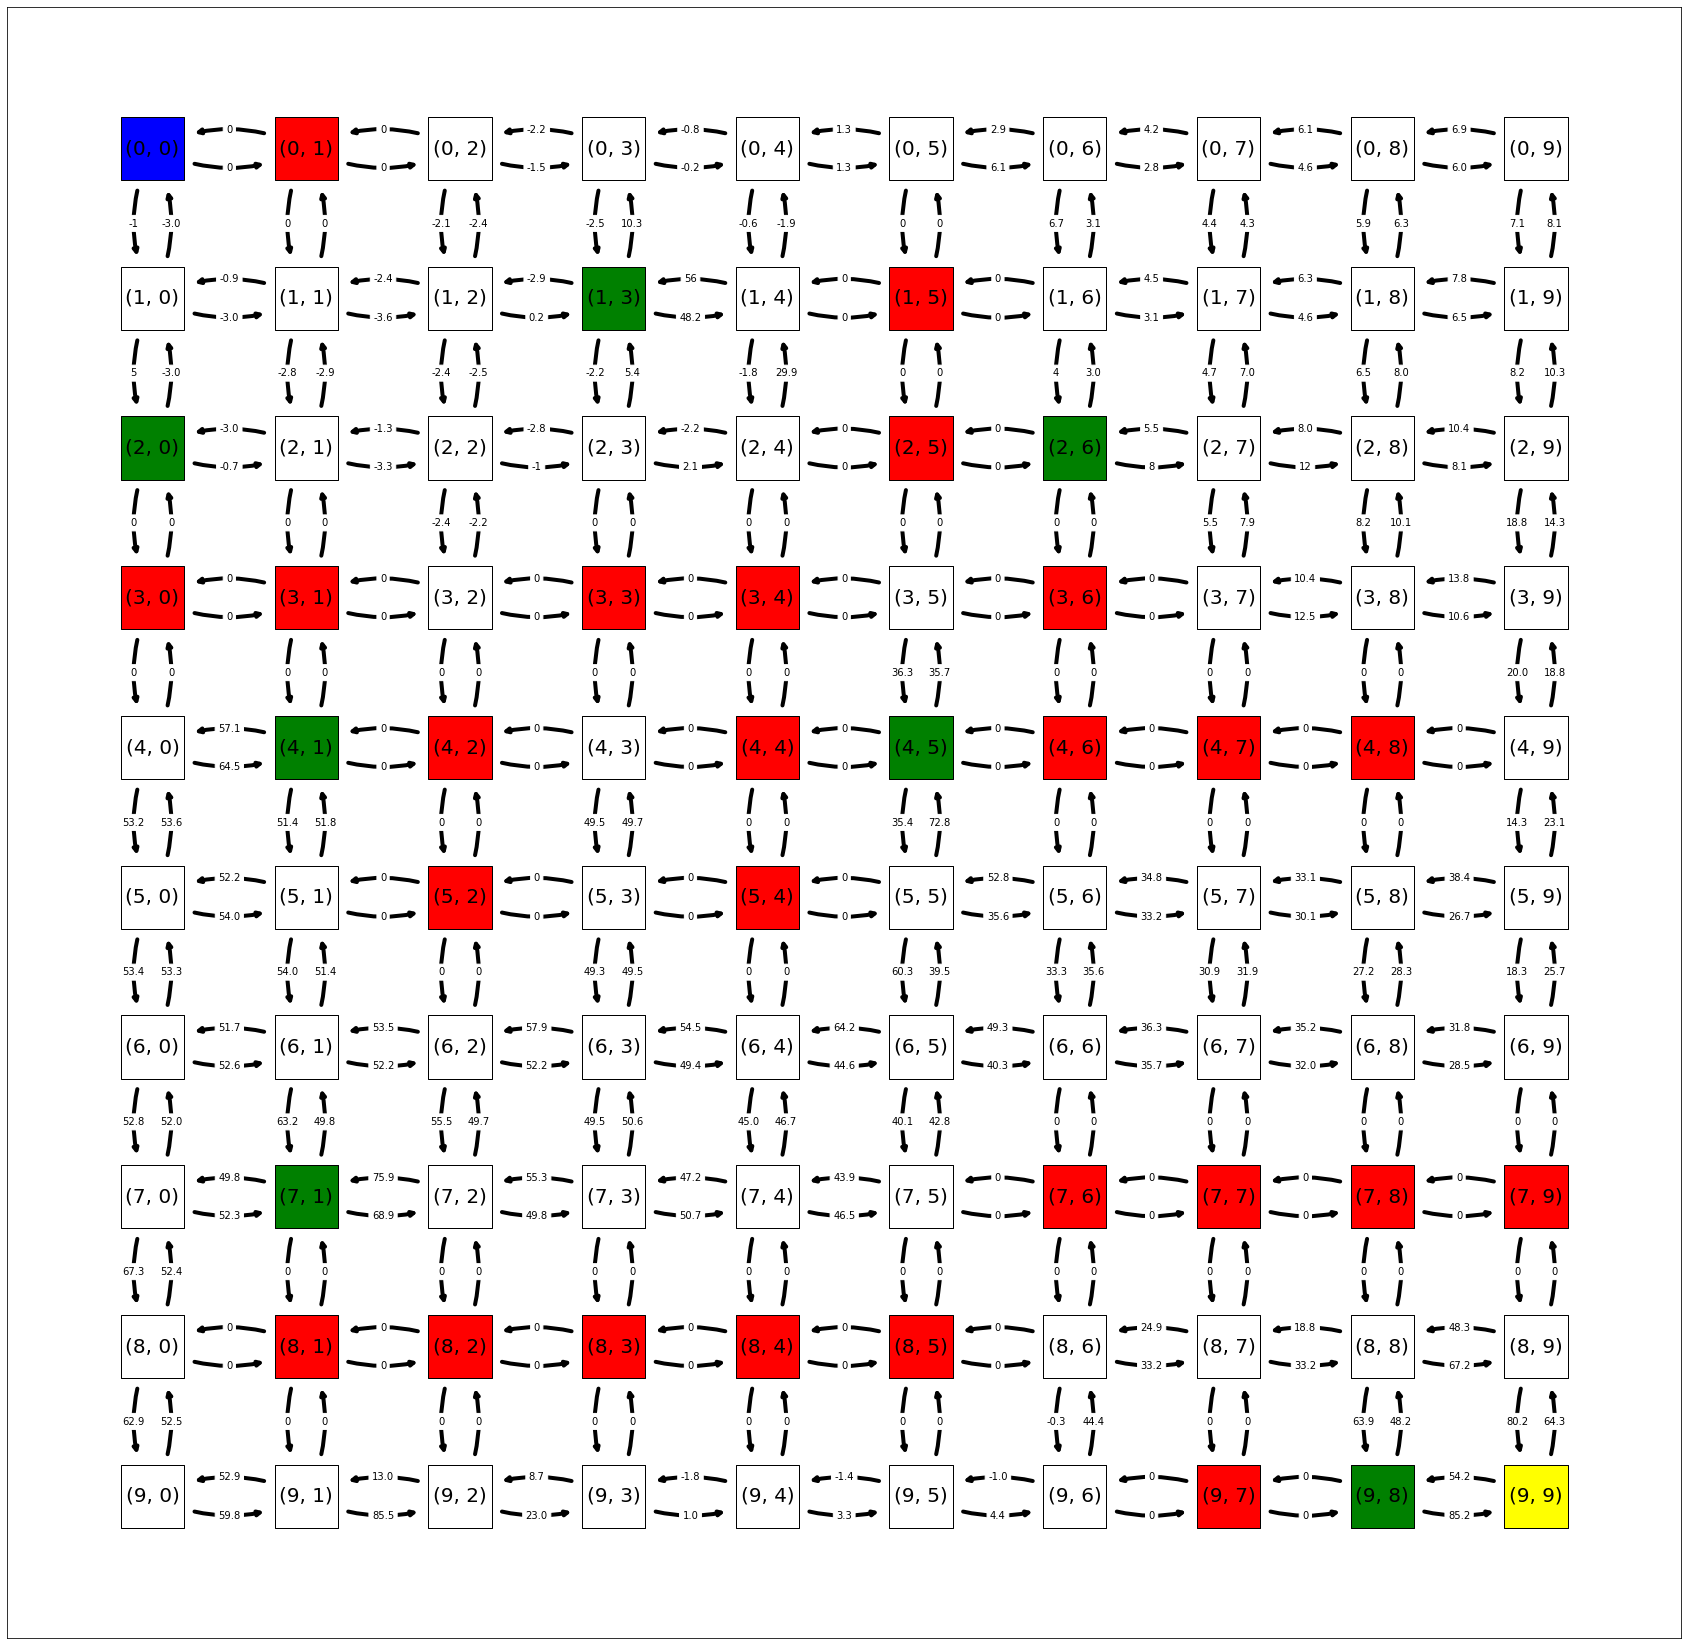

In [271]:
# best: alpha=0.1,gamma=1
alpha = 0.1
gamma = 1
epsilon = 1
episode_count = 10000
Q = Q_learning(environment,reward_map,alpha,gamma,epsilon,episode_count)
draw_Qtable(Q,table_size)

In [270]:
import pandas as pd
states = []
for i in range(len(environment)):
    for j in range(len(environment[0])):
        states.append((i, j))
Q_dic = {'L':[],'R':[],'U':[],'D':[]}
for state in states:
    for dirc in ['L','R','U','D']:
        Q_dic[dirc].append(np.round(Q[(state,dirc)],2))
pd.DataFrame(Q_dic,index=states).head(40)

,L,R,U,D
"(0, 0)",0.00,0.00,0.00,-1.00
"(0, 1)",0.00,0.00,0.00,0.00
"(0, 2)",0.00,-1.54,0.00,-2.06
"(0, 3)",-2.19,-0.20,0.00,-2.49
"(0, 4)",-0.77,1.25,0.00,-0.64
"(0, 5)",1.35,6.08,0.00,0.00
"(0, 6)",2.88,2.81,0.00,6.70
"(0, 7)",4.16,4.58,0.00,4.37
"(0, 8)",6.11,6.05,0.00,5.93
"(0, 9)",6.93,0.00,0.00,7.09


In [242]:
max_reward = -1000000
path_best = None
for i in range(1000):
    try:
        find_result,reward,path = get_path(environment,Q)
    except:
        continue
    if find_result and reward>max_reward:
        max_reward=reward
        path_best = path
path_best

[((0, 0), 'D'),
 ((1, 0), 'D'),
 ((2, 0), 'R'),
 ((2, 1), 'L'),
 ((2, 0), 'R'),
 ((2, 1), 'U'),
 ((1, 1), 'L'),
 ((1, 0), 'U'),
 ((0, 0), 'D'),
 ((1, 0), 'U'),
 ((0, 0), 'D'),
 ((1, 0), 'D'),
 ((2, 0), 'R'),
 ((2, 1), 'R'),
 ((2, 2), 'R'),
 ((2, 3), 'R'),
 ((2, 4), 'U'),
 ((1, 4), 'L'),
 ((1, 3), 'U'),
 ((0, 3), 'R'),
 ((0, 4), 'R'),
 ((0, 5), 'R'),
 ((0, 6), 'D'),
 ((1, 6), 'D'),
 ((2, 6), 'R'),
 ((2, 7), 'D'),
 ((3, 7), 'U'),
 ((2, 7), 'D'),
 ((3, 7), 'R'),
 ((3, 8), 'R'),
 ((3, 9), 'L'),
 ((3, 8), 'U'),
 ((2, 8), 'D'),
 ((3, 8), 'R'),
 ((3, 9), 'L'),
 ((3, 8), 'L'),
 ((3, 7), 'R'),
 ((3, 8), 'R'),
 ((3, 9), 'D'),
 ((4, 9), 'D'),
 ((5, 9), 'D'),
 ((6, 9), 'L'),
 ((6, 8), 'U'),
 ((5, 8), 'L'),
 ((5, 7), 'D'),
 ((6, 7), 'U'),
 ((5, 7), 'L'),
 ((5, 6), 'L'),
 ((5, 5), 'D'),
 ((6, 5), 'L'),
 ((6, 4), 'R'),
 ((6, 5), 'U'),
 ((5, 5), 'D'),
 ((6, 5), 'D'),
 ((7, 5), 'U'),
 ((6, 5), 'R'),
 ((6, 6), 'L'),
 ((6, 5), 'L'),
 ((6, 4), 'L'),
 ((6, 3), 'U'),
 ((5, 3), 'U'),
 ((4, 3), 'D'),
 ((5, 3)

In [257]:
def find_better_path(environment,path_in):
    def find_similar_state(i):
        for j in range(1,len(path)-i):
            state = path[i+j][0]
            if environment[state[0]][state[1]]=='F' and state not in seen_flags:
                return None
            if path[i+j][0]==path[i][0]:
                return j
        return None
    seen_flags = set()
    path = path_in.copy()
    i=0
    while i<len(path):
        state = path[i][0]
        if environment[state[0]][state[1]]=='F':
            seen_flags.add(state)
            
        j = find_similar_state(i)
        if j is not None:
            path = path[:i]+path[i+j:]
            #print(state)
            #print(j)
            #break
        else:
            i+=1
    return path
find_better_path(environment,[e for e in path_best])

[((0, 0), 'D'),
 ((1, 0), 'D'),
 ((2, 0), 'R'),
 ((2, 1), 'R'),
 ((2, 2), 'R'),
 ((2, 3), 'R'),
 ((2, 4), 'U'),
 ((1, 4), 'L'),
 ((1, 3), 'U'),
 ((0, 3), 'R'),
 ((0, 4), 'R'),
 ((0, 5), 'R'),
 ((0, 6), 'D'),
 ((1, 6), 'D'),
 ((2, 6), 'R'),
 ((2, 7), 'D'),
 ((3, 7), 'R'),
 ((3, 8), 'R'),
 ((3, 9), 'D'),
 ((4, 9), 'D'),
 ((5, 9), 'D'),
 ((6, 9), 'L'),
 ((6, 8), 'U'),
 ((5, 8), 'L'),
 ((5, 7), 'L'),
 ((5, 6), 'L'),
 ((5, 5), 'U'),
 ((4, 5), 'D'),
 ((5, 5), 'D'),
 ((6, 5), 'L'),
 ((6, 4), 'L'),
 ((6, 3), 'L'),
 ((6, 2), 'L'),
 ((6, 1), 'U'),
 ((5, 1), 'L'),
 ((5, 0), 'U'),
 ((4, 0), 'R'),
 ((4, 1), 'L'),
 ((4, 0), 'D'),
 ((5, 0), 'R'),
 ((5, 1), 'D'),
 ((6, 1), 'L'),
 ((6, 0), 'D'),
 ((7, 0), 'R'),
 ((7, 1), 'L'),
 ((7, 0), 'D'),
 ((8, 0), 'D'),
 ((9, 0), 'R'),
 ((9, 1), 'R'),
 ((9, 2), 'R'),
 ((9, 3), 'R'),
 ((9, 4), 'R'),
 ((9, 5), 'R'),
 ((9, 6), 'U'),
 ((8, 6), 'R'),
 ((8, 7), 'R'),
 ((8, 8), 'R'),
 ((8, 9), 'D'),
 ((9, 9), 'L'),
 ((9, 8), 'R')]